In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.abspath('..'))
from python_scripts.config import DT_MAX, DT_MIN, FINAL_P_SENSORS, Z_THRESH

## Connecting to SQL DB

In [2]:
# Create a connection to SQLite DB
engine = create_engine('sqlite:///../data/sensor_data.db')

# Tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", engine)
print("Tables in database:\n", tables)

# Load main table
df = pd.read_sql('SELECT * FROM capture_data', engine)

# Preview data
df.head()


Tables in database:
            name
0  capture_data


,id,cid,counter,tData,tData_2,tData_3,tData_4,pData,pData_2,pData_3,pData_4,created_at,updated_at
0,401,7,1693736755286,28,29,27,27,35,24,0,214,2023-09-03 12:25:55,2023-09-03 12:25:55
1,402,7,1693736755653,28,28,28,27,35,22,157,3,2023-09-03 12:25:56,2023-09-03 12:25:56
2,403,7,1693736755964,29,28,28,27,198,21,11,0,2023-09-03 12:25:56,2023-09-03 12:25:56
3,404,7,1693736756333,29,28,28,26,114,134,0,0,2023-09-03 12:25:56,2023-09-03 12:25:56
4,405,7,1693736756681,29,29,28,26,36,157,0,43,2023-09-03 12:25:57,2023-09-03 12:25:57


In [3]:
# basic info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107737 entries, 0 to 107736
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          107737 non-null  int64 
 1   cid         107737 non-null  int64 
 2   counter     107737 non-null  object
 3   tData       107737 non-null  int64 
 4   tData_2     107737 non-null  int64 
 5   tData_3     107737 non-null  int64 
 6   tData_4     107737 non-null  int64 
 7   pData       107737 non-null  int64 
 8   pData_2     107737 non-null  int64 
 9   pData_3     107737 non-null  int64 
 10  pData_4     107737 non-null  int64 
 11  created_at  107737 non-null  object
 12  updated_at  107737 non-null  object
dtypes: int64(10), object(3)
memory usage: 10.7+ MB


,id,cid,tData,tData_2,tData_3,tData_4,pData,pData_2,pData_3,pData_4
count,107737.000000,107737.000000,107737.000000,107737.000000,107737.000000,107737.000000,107737.000000,107737.000000,107737.000000,107737.000000
mean,54482.539499,201.134773,-386.572153,-387.113601,-390.207180,-392.290420,30.968395,20.930238,9.353305,13.231369
std,31103.053840,124.449195,7609.059917,7609.032447,7608.864815,7608.762206,149.725734,144.651126,93.783207,266.105222
min,401.000000,0.000000,-141804.000000,-141804.000000,-141804.000000,-141804.000000,0.000000,0.000000,0.000000,0.000000
25%,27548.000000,83.000000,21.000000,21.000000,9.000000,9.000000,0.000000,0.000000,0.000000,0.000000
50%,54482.000000,190.000000,24.000000,24.000000,23.000000,23.000000,37.000000,20.000000,0.000000,0.000000
75%,81416.000000,295.000000,30.000000,30.000000,26.000000,28.000000,43.000000,30.000000,5.000000,0.000000
max,109895.000000,446.000000,77.000000,83.000000,83.000000,83.000000,9893.000000,9893.000000,9893.000000,9893.000000


## Converting time data

In [4]:
df['cid'].nunique(), df['cid'].value_counts().head()

# convert time columns
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])


df['counter'] = pd.to_numeric(df['counter'], errors='coerce')

# convert "counter" to second if ms in the dataset:
if df['counter'].max() > 1e12:
    df['t'] = pd.to_datetime(df['counter'], unit='ms')
else:
    df['t'] = pd.to_datetime(df['counter'], unit='s')

# sort & check sampling rate
df = df.sort_values(['cid','t'])

# compute time intervals
df['dt'] = df.groupby('cid')['t'].diff().dt.total_seconds()

df['dt'].describe()

count    1.073850e+05
mean     4.072836e+02
std      5.050160e+04
min      0.000000e+00
25%      3.320000e-01
50%      3.590000e-01
75%      3.690000e-01
max      1.488521e+07
Name: dt, dtype: float64

In [5]:
df.isnull().values.any()

df.isnull().sum()

df.select_dtypes(include="number").isnull().sum()

id           0
cid          0
counter      0
tData        0
tData_2      0
tData_3      0
tData_4      0
pData        0
pData_2      0
pData_3      0
pData_4      0
dt         352
dtype: int64

## Visualising raw data

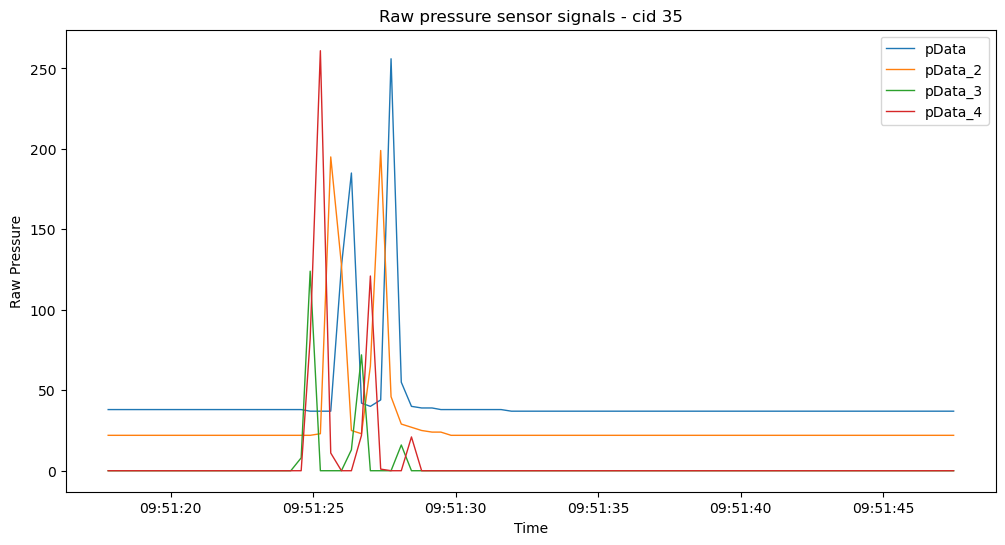

In [6]:
df_raw = pd.read_sql('SELECT * FROM capture_data', engine)

# convert timestamps
df_raw['counter'] = pd.to_numeric(df_raw['counter'], errors='coerce')
df_raw['t'] = pd.to_datetime(df_raw['counter'], unit='ms')

cid_sample = df_raw['cid'].unique()[20]
df = df_raw[df_raw['cid'] == cid_sample].copy()

SENSORS = ['pData', 'pData_2', 'pData_3', 'pData_4']

plt.figure(figsize=(12, 6))
for c in SENSORS:
    plt.plot(df['t'], df[c], label=c, linewidth=1)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Raw Pressure")
plt.title(f"Raw pressure sensor signals - cid {cid_sample}")
plt.show()



/var/folders/r6/3v7mcgpd0xvcjlw0flypmbv80000gn/T/ipykernel_16866/1672580553.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  raw['t'] = pd.to_datetime(raw['counter'], unit='ms')


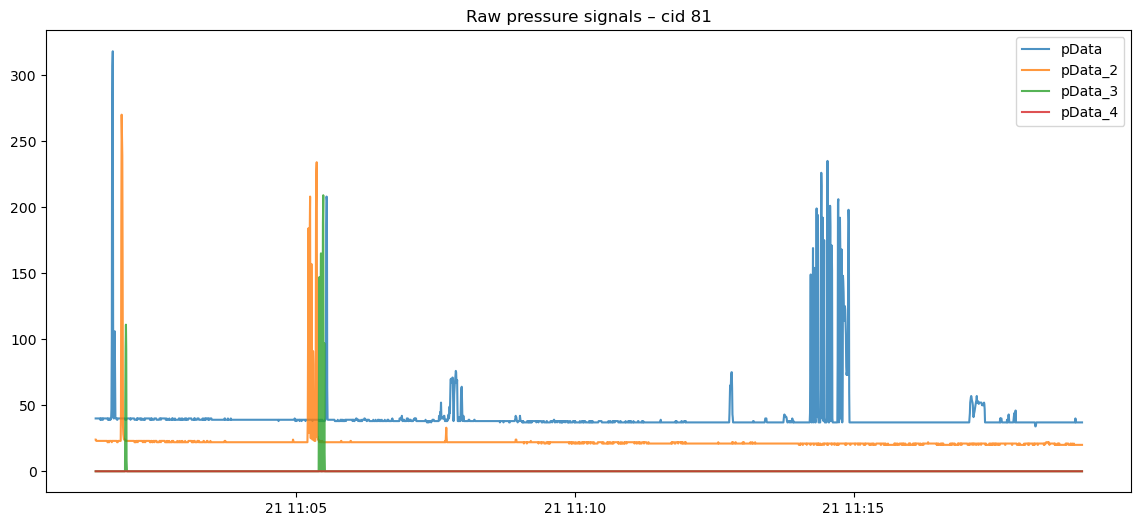

In [7]:
engine = create_engine('sqlite:///../data/sensor_data.db')
raw = pd.read_sql('SELECT * FROM capture_data', engine)

raw['t'] = pd.to_datetime(raw['counter'], unit='ms')

cid = raw['cid'].value_counts().idxmax()
g = raw[raw['cid'] == cid].iloc[:3000]

plt.figure(figsize=(14,6))
for c in ["pData", "pData_2", "pData_3", "pData_4"]:
    plt.plot(g['t'], g[c], label=c, alpha=0.8)

plt.legend()
plt.title(f"Raw pressure signals – cid {cid}")
plt.show()


CIDs with active pData_4: 160


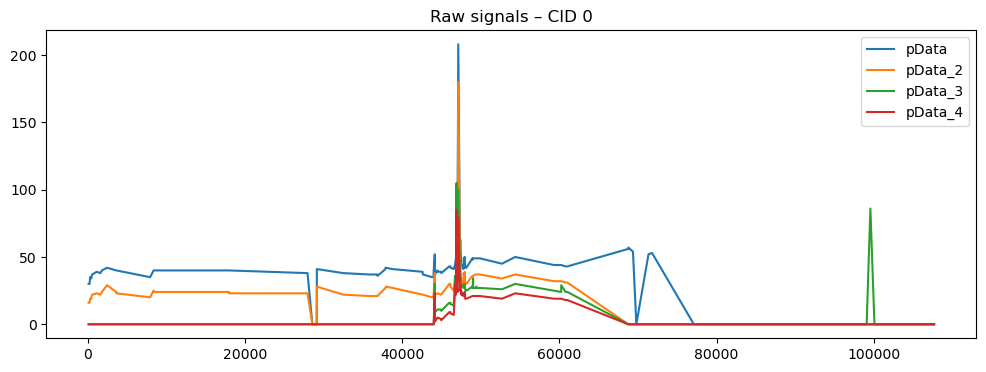

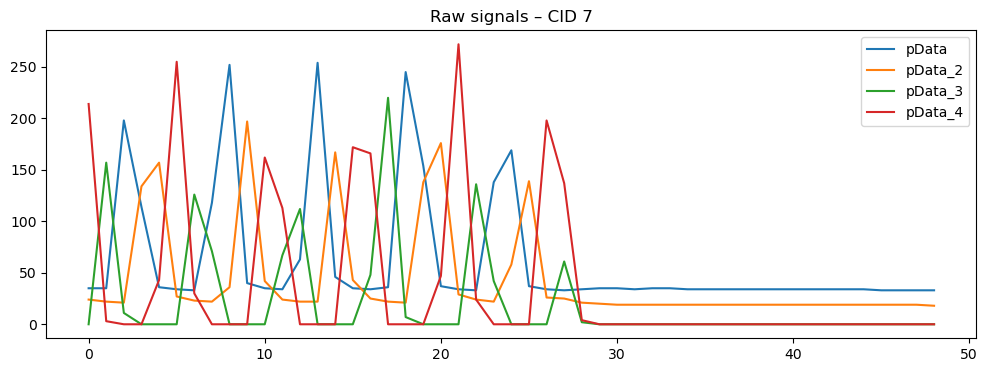

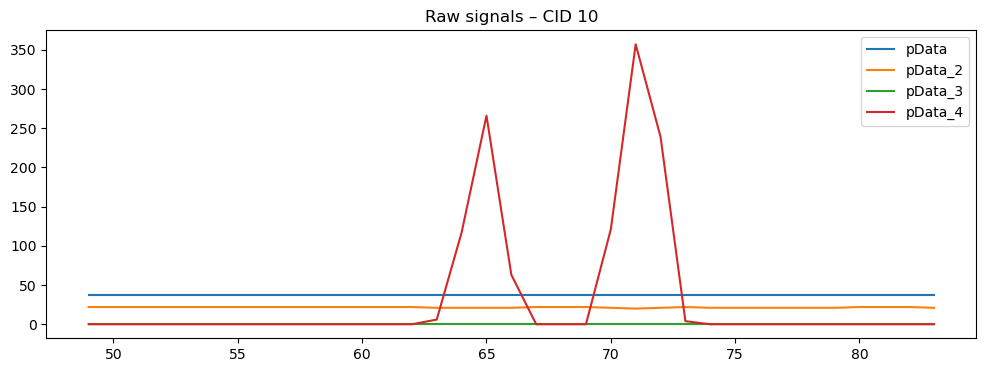

In [8]:
import matplotlib.pyplot as plt

raw = pd.read_sql('SELECT * FROM capture_data', engine)

summary = raw[["pData", "pData_2", "pData_3", "pData_4"]].agg(
    ["count", "mean", "std", "min", "max"]
)

summary

cid_activity = (
    raw.groupby("cid")[["pData", "pData_2", "pData_3", "pData_4"]]
       .std()
       .reset_index()
)

cid_activity.head()

active_pdata4 = cid_activity[cid_activity["pData_4"] > 1]

print("CIDs with active pData_4:", len(active_pdata4))
active_pdata4.head(10)



def plot_raw_cid(cid, n=2000):
    g = raw[raw["cid"] == cid].head(n)

    plt.figure(figsize=(12,4))
    plt.plot(g["pData"], label="pData")
    plt.plot(g["pData_2"], label="pData_2")
    plt.plot(g["pData_3"], label="pData_3")
    plt.plot(g["pData_4"], label="pData_4")
    plt.title(f"Raw signals – CID {cid}")
    plt.legend()
    plt.show()

# CIDs where pData_4 seems active
for cid in active_pdata4["cid"].head(3):
    plot_raw_cid(cid)


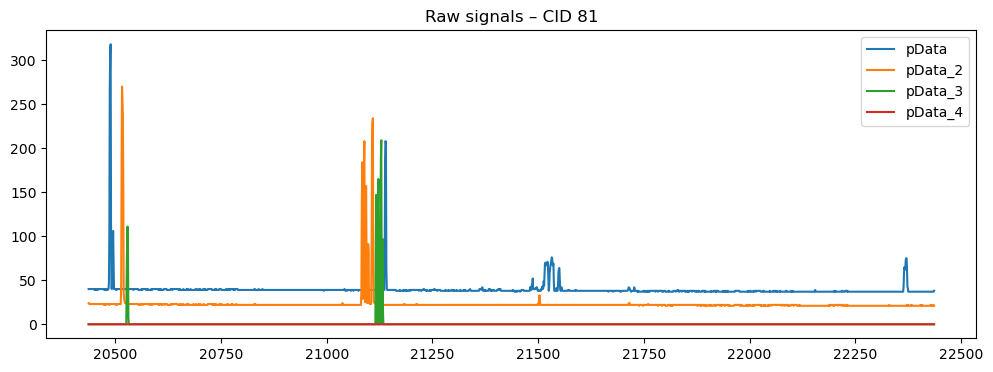

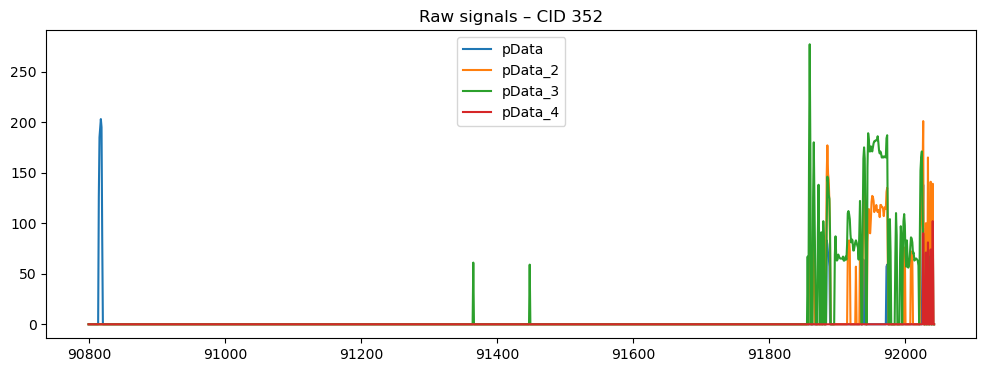

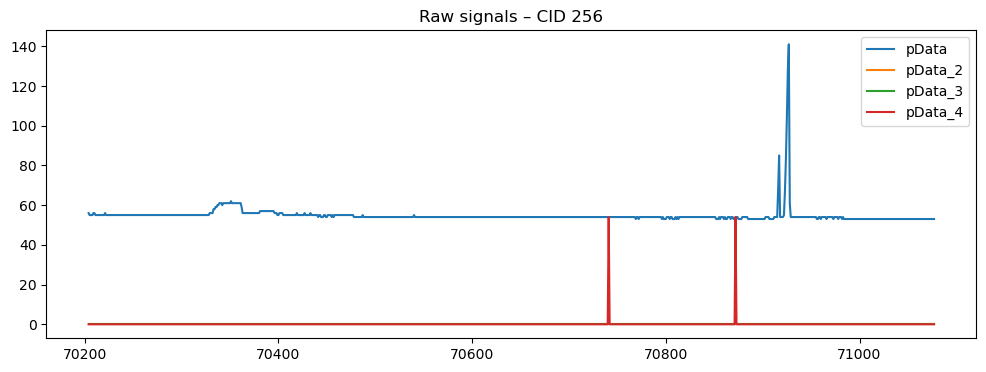

In [ ]:
for cid in raw["cid"].sample(3):
    plot_raw_cid(cid)
